# Classify + Predict Success on The Bachelor

In [63]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import json
import math
import itertools

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


First we import all data sources

In [2]:
#Import all data sources

#Twitter
with open("twitter_sentiment.json") as json_file:
    twitter = json.load(json_file)
    
#Distances
with open("distances.json") as json_file:
    distances = json.load(json_file)
    
#Geo-Cluster
with open("geo_cluster.json") as json_file:
    geo_cluster = json.load(json_file)
    
#Profession
with open("profession_dict.json") as json_file:
    professions = json.load(json_file)
    
#Wiki Info
wiki = pd.read_csv("contestantDF.csv")

#Date Guide
date_guide = pd.read_csv("date_guide.csv")

#Competition Data
with open("competition_data.json") as json_file:
    comp = json.load(json_file)

In [6]:
#Rename Wiki Dataframe - column elimination week
#If a winner - eliminated week 11, if runner-up - eliminated week 10
#If bachelor - eliminated week 0
#If season 13-14, if elimination week = 2-8, add 2

new_elim=  wiki['elimination week'].tolist()
new_elim = ['11' if qq=="Winner" else qq for qq in new_elim]
new_elim = ['10' if qq=="Runner-up" else qq for qq in new_elim]
new_elim = ['0' if qq=="bachelor" else qq for qq in new_elim]
new_elim = [qq.split(" ")[-1] for qq in new_elim]

all_seasons = wiki['season'].tolist()

good_elim = []

for elim, season in zip(new_elim, all_seasons):
    if season in [13,14] and int(elim) > 1 and int(elim) < 10:
        good_elim.append(str(int(elim)+2))
    else:
        good_elim.append(elim)
        
wiki["good_elim"] = good_elim

## Fitting a Classifier

We fit a different classifier for each elimination week of the Bachelor.

We use a Logistic Classifier with an L1 penalty - similar to the process of HW3. Our response variable is whether the contestant was eliminated or advanced past that week's competition.

In [7]:
#Borrow the do_classify and cv_optimize functions from HW3
#These will help us get the best hyperparameters for our classifier
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

#We also borrow cv_optimize from HW3 which runs a gridSearch to find best hyperparameters
#This function is nested inside the do_classify function
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):    
    #Run a grid search with or without a custom scoring function
    if score_func:
        grid_search = GridSearchCV(clf, param_grid=parameters, cv=n_folds, 
                                   n_jobs=1, scoring=score_func)
    else:
        grid_search = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=1)
        
    #Fit the data based grid search
    grid_search.fit(X,y)
    
    #Grab the best estimator
    best = grid_search.best_estimator_
    
    return best

### Week 1

We start with Week 1, where we predict performance based on each contestant's fundamental data.

In [8]:
#Week 1 - Based only on fundamentals data
#Where fundamentals = geo-cluster, profession, age, photo, distances
week1_contestants = wiki[wiki['good_elim'] != "0"]
week1_success = week1_contestants['good_elim']!="1"
all_bach = wiki[wiki['good_elim'] == "0"]

#Get all data sources from libraries
distances_series = []
geo_series = []
profession_series = []
age_diff_series = []
for season, cname, cage in zip(week1_contestants['season'],week1_contestants['name'], \
                              week1_contestants['age']):
    distances_series.append(distances[str(season)][cname])
    geo_series.append(geo_cluster[str(season)][cname])
    profession_series.append(professions[str(season)][cname])
    
    age_diff_series.append(int(all_bach[all_bach["season"]==season]["age"]) - int(cage))
    
age_series = week1_contestants['age']

#Normalize distances
def normal_func(a_series):
    meanval = np.mean(a_series)
    sdval = np.std(a_series)
    return [(qq - meanval) / sdval for qq in a_series]

distances_norm = normal_func(distances_series)

#Put data into pandas dataframe
week1_data = pd.DataFrame({"SUCCESS": week1_success, "DIST": distances_series, \
                           "GEO": geo_series, "PROF":profession_series, \
                           "AGE_DIFF":age_diff_series, "AGE":age_series, \
                           "DIST_NORM": distances_norm})

To find the best hyperparameters for the logistic classifier, we borrow the do_classify and cv_optimize functions from HW3. The do_classify function takes our predictor/response dataframe, and fits/tests the best classifier returned from cv_optimize. The function cv_optimize runs a grid search over a list of hyperparameters with n-fold cross-validation, and returns the classfier with optimal hyperparameter (i.e. regularization) that best fits the training data. We report the training and test accuracy of the classifier

using mask
############# based on standard predict ################
Accuracy on training data: 0.66
Accuracy on test data:     0.72
[[ 0 16]
 [ 0 41]]
########################################################
0.719298245614
0.664122137405
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


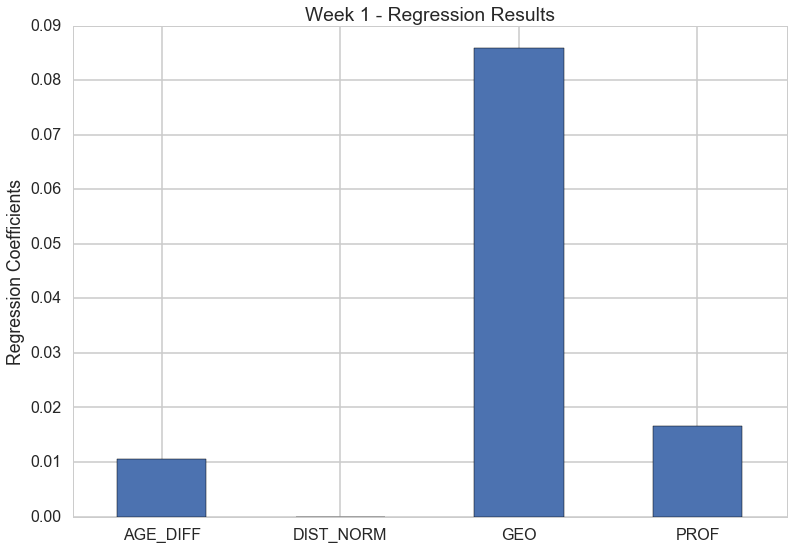

In [10]:
#Make training/test masks
itrain, itest = train_test_split(xrange(week1_data.shape[0]), train_size=0.7)
mask=np.ones(week1_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week1_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=10)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col)
plt.ylabel("Regression Coefficients")
plt.title("Week 1 - Regression Results")
plt.show()

## Get Data / Fit Classifier for Other Weeks

We define a function that pulls in all our data depending on the elimination week in question. These data include fundamentals, twitter data, and date outcomes. 

An additional caveat is that between seasons 14 and 15, The Bachelor expanded from an 8 episode to a 10 episode format. Thus to try and keep the data consistent, we only do analyses for weeks 2 and 3 on the season 15-19 data. When we get to Week 4 - we will use Week 2 data from seasons 13 and 14.

In [11]:
#Define a function to get all data for a certain week 
def get_week_data(which_week, early_episode):
    
    if which_week == 2:
        select_week = ["0", "1"]
    else:
        select_week = ["0"] + [str(qq) for qq in range(1,which_week)]
    week_contestants = wiki[~wiki['good_elim'].isin(select_week)]
    season_range=range(13,20)
    if early_episode:
        week_contestants = week_contestants[~wiki['season'].isin([13,14])]
        season_range = range(15,20)
    week_success = week_contestants['good_elim']!=str(which_week)
    all_bach = wiki[wiki['good_elim'] == "0"]
    
    #Get right episode dates
    right_dates = date_guide[date_guide['Episode']==which_week]
    right_dates = right_dates[right_dates['Season'].isin(season_range)]

    #Get all data sources from libraries
    distances_series = []
    geo_series = []
    profession_series = []
    age_diff_series = []
    num_tweets = []
    tweet_sent = []
    group_rose = []
    date_rose = []
    group_date = []
    total_roses_season = []
    total_season_tweets = dict(zip(season_range, np.zeros(len(season_range))))
    for season, cname, cage in zip(week_contestants['season'],week_contestants['name'], \
                                  week_contestants['age']):
        #Get distances / spatial cluster
        distances_series.append(distances[str(season)][cname])
        geo_series.append(geo_cluster[str(season)][cname])

        #Get profession
        profession_series.append(professions[str(season)][cname])

        #Get Age Difference
        age_diff_series.append(int(all_bach[all_bach["season"]==season]["age"]) - int(cage))

        #Get Twitter Data
        tname = cname.split(" ")[0]
        try:
            episode = right_dates[right_dates['Season']==season]['Date'].tolist()[0]
            right_tweets = twitter[str(season)][tname][str(episode)]
            num_tweets.append(right_tweets["ntweet"])
            tweet_sent.append(right_tweets["sentiment"])
            total_season_tweets[season] = total_season_tweets[season] + right_tweets["ntweet"]
        except:
            num_tweets.append(0)
            tweet_sent.append(0)
            
        #Get competition Data
        season_dat = wiki[wiki['season'] == season].copy()
        season_dat['firstname'] = [qq.split(" ")[0] for qq in season_dat['name'].tolist()]
        first_names_all = season_dat['name'].groupby(season_dat['firstname']).count()
        first_names = dict(zip(first_names_all.index.tolist(), first_names_all.tolist()))
        
        if first_names[tname] == 2:
            comp_name = cname.split(" ")[0] + " " + cname.split(" ")[1][0]
        else:
            comp_name = tname
        
        if which_week != 2:
            try:
                daters = comp[str(season)][str(which_week - 1)].keys()
                if comp_name in daters:
                    contestant_date = comp[str(season)][str(which_week - 1)][comp_name]
                    if "grou" in contestant_date.keys()[0]:
                        group_date.append(1)
                        date_rose.append(0)
                        if contestant_date.values() == True:
                            group_rose.append(1)
                        else:
                            group_rose.append(0)
                    else:
                        group_date.append(0)
                        group_rose.append(0)
                        if contestant_date.values()[0] == True:
                            date_rose.append(1)
                        else:
                            date_rose.append(0)
                else:
                    group_date.append(0)
                    group_rose.append(0)
                    date_rose.append(0)
            except:
                group_date = np.zeros(len(num_tweets))
                group_rose = np.zeros(len(num_tweets))
                date_rose = np.zeros(len(num_tweets))
                
        else:
            group_date = np.zeros(len(num_tweets))
            group_rose = np.zeros(len(num_tweets))
            date_rose = np.zeros(len(num_tweets))
                    
    #Get Tweet Share - i.e. proportion of contestant tweets to total tweets / episode
    tweet_share = []
    for season, ntweet in zip(week_contestants['season'], num_tweets):
        tweet_share.append(ntweet/float(total_season_tweets[season]))

    #Get raw age of each contestant
    age_series = week_contestants['age']

    #Normalize distances
    def normal_func(a_series):
        meanval = np.mean(a_series)
        sdval = np.std(a_series)
        return [(qq - meanval) / sdval for qq in a_series]

    distances_norm = normal_func(distances_series)

    #Put data into pandas dataframe
    week_data = pd.DataFrame({"SUCCESS": week_success, "DIST": distances_series, \
                               "GEO": geo_series, "PROF":profession_series, \
                               "AGE_DIFF":age_diff_series, "AGE":age_series, \
                               "DIST_NORM": distances_norm, "TSENT": tweet_sent, \
                              "TWEET_SHARE": tweet_share, "GROSE": group_rose, \
                             "GDATE": group_date, "ODATE": date_rose})
    
    return week_data, week_success


In [91]:
# Get normalized values per season per episode twitter

def get_max_min_tweet(season):
    #Get all episode dates
    all_dates = []

    for tt in twitter[season].values():
        all_dates.append(tt.keys())

    all_dates_flat = list(itertools.chain.from_iterable(all_dates))
    unique_dates = [ss for ss in set(all_dates_flat)]

    #Count all tweets per episode
    Maxtweet = []
    Mintweet = []
    for this_date in unique_dates:
        ep_tweet = []
        for all_cont in twitter[season].values():
            try:
                ep_tweet.append(all_cont[this_date]['ntweet'])
            except:
                ""
        Maxtweet.append(np.max(ep_tweet))
        Mintweet.append(np.min(ep_tweet))


    tMAX_dict = dict(zip(unique_dates, Maxtweet))
    tMIN_dict = dict(zip(unique_dates, Mintweet))

    return tMAX_dict, tMIN_dict

#Define another function to get weekly data - but just success and twitter

season='15'

In [116]:
def get_week(which_week, early_episode):
    if which_week == 2:
        select_week = ["0", "1"]
    else:
        select_week = ["0"] + [str(qq) for qq in range(1,which_week)]
    week_contestants = wiki[~wiki['good_elim'].isin(select_week)]
    season_range=range(13,20)
    if early_episode:
        week_contestants = week_contestants[~wiki['season'].isin([13,14])]
        season_range = range(15,20)
    week_success = week_contestants['good_elim']!=str(which_week)
    all_bach = wiki[wiki['good_elim'] == "0"]
    
    #Get right episode dates
    right_dates = date_guide[date_guide['Episode']==which_week]
    right_dates = right_dates[right_dates['Season'].isin(season_range)]

    tweet_norm = []
    for season, cname, cage in zip(week_contestants['season'],week_contestants['name'], \
                                  week_contestants['age']):
        #Get Twitter Data
        tname = cname.split(" ")[0]
        tMAX, tMIN = get_max_min_tweet(str(season))
        try:
            episode = right_dates[right_dates['Season']==season]['Date'].tolist()[0]
            ntweet = twitter[str(season)][tname][str(episode)]['ntweet']
            nrm =(ntweet - tMIN[str(episode)]) / float(tMAX[str(episode)] - tMIN[str(episode)])
            tweet_norm.append(nrm)
        except:
            tweet_norm.append(0)

    week_data = pd.DataFrame({"SUCCESS": week_success, "TNORM": tweet_norm})
    return week_data, week_success



### Week 2

In [140]:
week2_data, week2_success = get_week_data(2, True)

#Make training/test masks
itrain, itest = train_test_split(xrange(week2_data.shape[0]), train_size=0.7)
mask=np.ones(week2_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
#pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE']

#Make Predictor soley off of twitter share
pred_col = ['TWEET_SHARE']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week2_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

#plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
#plt.xticks(range(len(clf.coef_[0])), pred_col)
#plt.ylabel("Regression Coefficients")
#plt.title("Week 2 - Regression Results")
#plt.show()

using mask
############# based on standard predict ################
Accuracy on training data: 0.99
Accuracy on test data:     0.90
[[ 3  0]
 [ 3 24]]
########################################################
0.9
0.808823529412
[1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Now that we have the classifier for week 2, let's use season 20 data as the final test set and predict probabilities of advancing for each contestant

In [141]:
with open("week1.json") as json_file:
    week1_tweets = json.load(json_file)

In [145]:
#Convert share into right array format
#tweet_share = [[0] if tt<.01 else [tt] for tt in week1_tweets.values()]
tweet_share = [[tt] for tt in week1_tweets.values()]
cont_name = [nn for nn in week1_tweets.keys()]

prob_dict = dict(zip(cont_name, 100*clf.predict_proba(tweet_share)[:,1]))


In [146]:
output1 = pd.DataFrame(prob_dict.items(), columns= ["Names", "Probability"])

output1

Names  Probability
0       Amber   100.000000
1     Jubilee   100.000000
2       Emily    99.958810
3   Shushanna    99.979568
4    Lauren H    78.707458
5       Caila    94.996622
6        JoJo    99.982345
7        Leah    99.832747
8      Rachel    99.987566
9       Haley    97.065694
10     Jackie    97.147786
11   Jennifer    98.924567
12     Amanda   100.000000
13      Becca    52.730811
14     Olivia   100.000000
15   Samantha    99.999978
16         LB    95.267202
17   Lauren B   100.000000
18      Mandi   100.000000
19       Jami    96.423529
20       Lace   100.000000

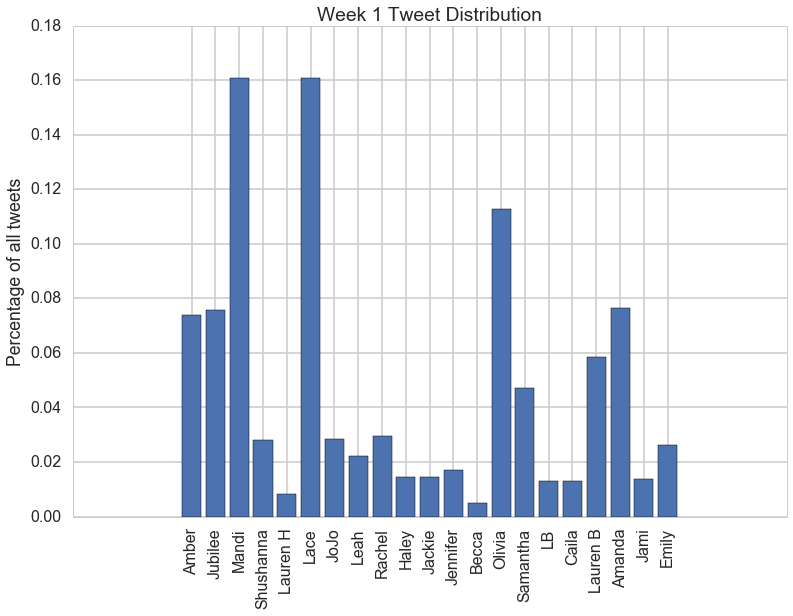

In [139]:
plt.bar(range(len(week1_tweets)), week1_tweets.values(), align="center")
plt.xticks(range(len(week1_tweets)), week1_tweets.keys(), rotation=90)
plt.title("Week 1 Tweet Distribution")
plt.ylabel("Percentage of all tweets")
plt.show()


### Week 3

In [137]:
week3_data, week3_success = get_week(3, True)

#Make training/test masks
itrain, itest = train_test_split(xrange(week3_data.shape[0]), train_size=0.7)
mask=np.ones(week3_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
#pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE', \
#            'GROSE', 'GDATE', 'ODATE']

pred_col = ['TNORM']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week3_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)


using mask
############# based on standard predict ################
Accuracy on training data: 0.91
Accuracy on test data:     0.92
[[ 6  0]
 [ 2 17]]
########################################################
0.76
0.859649122807
[1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### Week 4

using mask
############# based on standard predict ################
Accuracy on training data: 0.96
Accuracy on test data:     0.95
[[ 4  1]
 [ 0 16]]
########################################################
0.761904761905
0.829787234043
[1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


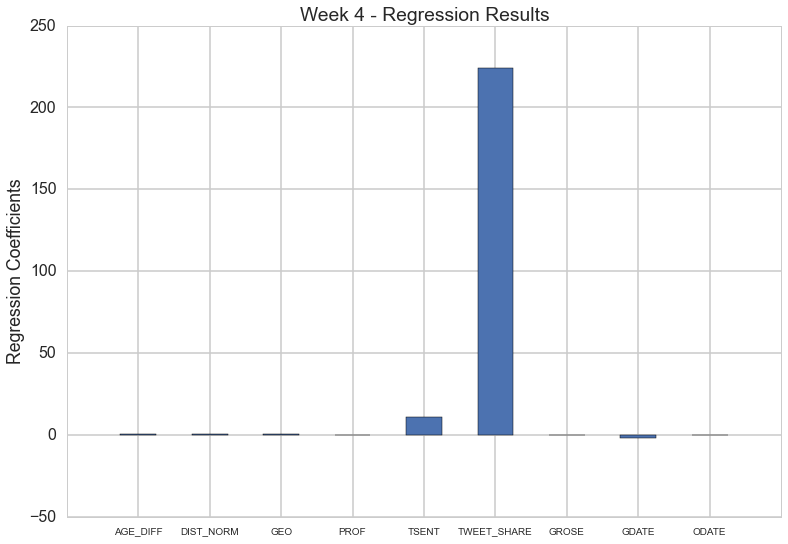

In [117]:
week4_data, week4_success = get_week_data(4, True)

#Make training/test masks
itrain, itest = train_test_split(xrange(week4_data.shape[0]), train_size=0.7)
mask=np.ones(week4_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE', \
            'GROSE', 'GDATE', 'ODATE']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week4_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, fontsize=10)
plt.ylabel("Regression Coefficients")
plt.title("Week 4 - Regression Results")
plt.show()

### Week 5

using mask
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.88
[[ 3  3]
 [ 0 18]]
########################################################
0.75
0.781818181818
[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


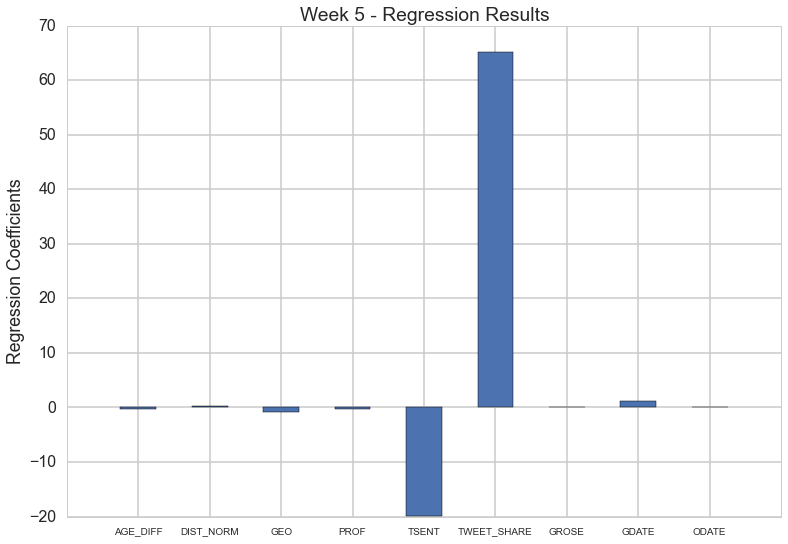

In [134]:
week5_data, week5_success = get_week_data(5, False)

#Make training/test masks
itrain, itest = train_test_split(xrange(week5_data.shape[0]), train_size=0.7)
mask=np.ones(week5_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE', \
            'GROSE', 'GDATE', 'ODATE']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week5_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, fontsize=10)
plt.ylabel("Regression Coefficients")
plt.title("Week 5 - Regression Results")
plt.show()

### Week 6

using mask
############# based on standard predict ################
Accuracy on training data: 0.88
Accuracy on test data:     0.95
[[ 7  0]
 [ 1 11]]
########################################################
0.631578947368
0.666666666667
[1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


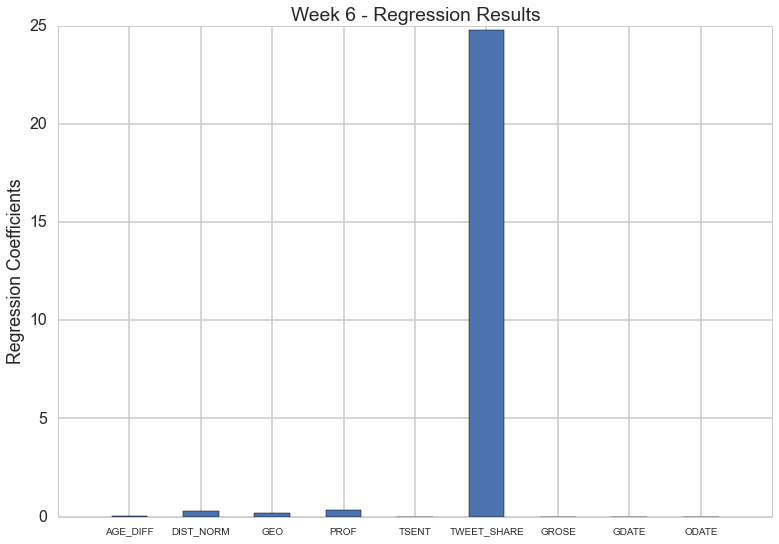

In [125]:
week6_data, week6_success = get_week_data(6, False)

#Make training/test masks
itrain, itest = train_test_split(xrange(week6_data.shape[0]), train_size=0.7)
mask=np.ones(week6_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE', \
            'GROSE', 'GDATE', 'ODATE']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week6_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, fontsize=10)
plt.ylabel("Regression Coefficients")
plt.title("Week 6 - Regression Results")
plt.show()

using mask
############# based on standard predict ################
Accuracy on training data: 0.89
Accuracy on test data:     0.75
[[3 2]
 [1 6]]
########################################################
0.583333333333
0.75
[1 0 0 1 1 1 1 1 0 1 1 0]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


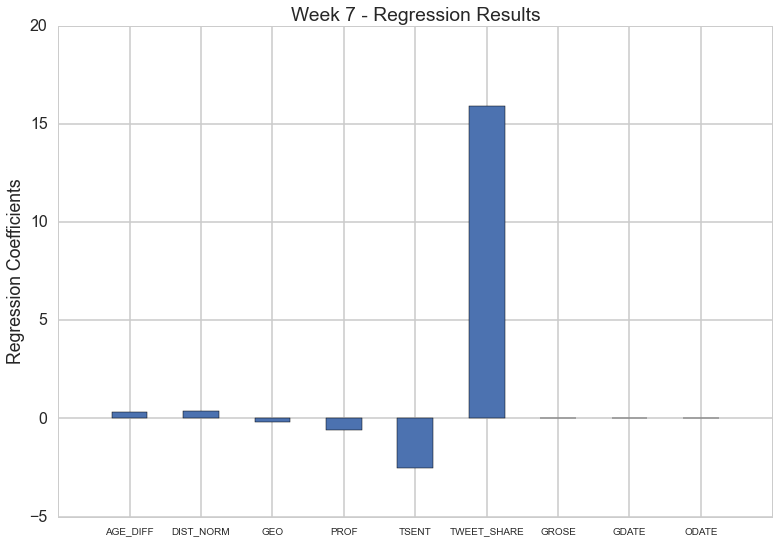

In [127]:
week7_data, week7_success = get_week_data(7, False)

#Make training/test masks
itrain, itest = train_test_split(xrange(week7_data.shape[0]), train_size=0.7)
mask=np.ones(week7_data.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#Find the best logistic classifier - report accuracy
CC = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
pred_col = ['AGE_DIFF', 'DIST_NORM', 'GEO', 'PROF', 'TSENT', 'TWEET_SHARE', \
            'GROSE', 'GDATE', 'ODATE']
clf, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"), \
                                                   CC, week7_data, pred_col, \
                                                   'SUCCESS',1, mask=mask, n_folds=3)

print sum(ytest) / float(len(ytest))
print sum(ytrain) / float(len(ytrain))
print clf.predict(Xtest)

plt.bar(range(len(clf.coef_[0])),clf.coef_[0], align="center", width=.5)
plt.xticks(range(len(clf.coef_[0])), pred_col, fontsize=10)
plt.ylabel("Regression Coefficients")
plt.title("Week 7 - Regression Results")
plt.show()

In [213]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

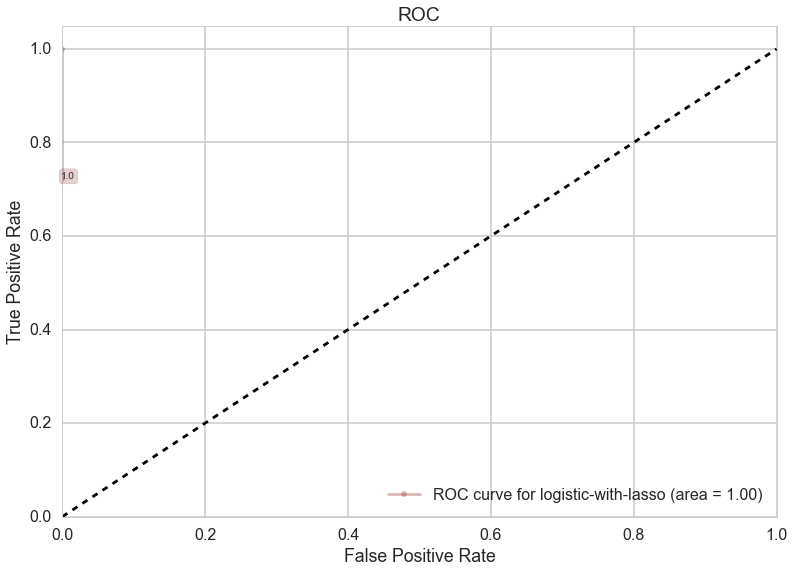

In [214]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clf, ytest, Xtest, labe=50, skip=5)

In [21]:
week1_data

AGE  AGE_DIFF         DIST  DIST_NORM  GEO  PROF SUCCESS
0     25         8  1025.064422  -0.182737    5     5    True
1     24         9   226.889927  -1.206627    4     3    True
2     29         4  1879.977325   0.913936    7     2    True
3     24         9  2026.201031   1.101511    6     5    True
4     34        -1   538.679446  -0.806667    3     3    True
5     27         6   397.346118  -0.987968    2     2    True
6     25         8   103.284845  -1.365186    1     3    True
7     29         4   627.494033  -0.692736    5     3    True
8     29         4   309.413472  -1.100767    4     3    True
9     25         8   439.699607  -0.933637    1     1    True
10    27         6   692.441571  -0.609422    5     1    True
11    27         6   409.143801  -0.972834    4     1    True
12    27         6  4525.683265   4.307820    7     2    True
13    32         1   206.839372  -1.232348    1     2    True
14    28         5  1749.809180   0.746958    6     3    True
15    24         9  1746.045308   0.742130    5     5   False
16    26         7   279.068189  -1.139693    1     5   False
17    23        10  2020.460391   1.094146    6     1   False
18    26         7   472.724684  -0.891273    1     2   False
19    26         7   126.687748  -1.335165    2     2   False
20    25         8  1663.647537   0.636431    7     3   False
21    36        -3   103.135237  -1.365378    4     2   False
22    23        10  2099.934631   1.196095    6     1   False
23    24         9  1561.204469   0.505018    6     3   False
24    28         5  1564.286643   0.508972    6     3   False
25    23         9   970.915710  -0.252199    3     1    True
26    25         7  1638.689701   0.604415    6     2    True
27    26         6  1371.988917   0.262294    1     5    True
28    25         7  1453.479117   0.366829    1     1    True
29    23         9   965.750991  -0.258824    3     4    True
..   ...       ...          ...        ...  ...   ...     ...
158   29         4   439.035263  -0.934489    2     3    True
159   26         7   719.063068  -0.575272    3     3    True
160   29         4  1237.029084   0.089169    7     3    True
161   28         5   615.636795  -0.707947    5     2    True
162   29         4   752.535105  -0.532335    5     5    True
163   27         6  1553.488583   0.495120    6     5    True
164   24         9   524.559828  -0.824779    2     2    True
165   28         5   294.384022  -1.120046    4     2    True
166   26         7   793.712965  -0.479512    2     2    True
167   21        12  1506.237706   0.434507    6     3    True
168   27         6   352.612387  -1.045352    4     2    True
169   24         9   923.944104  -0.312453    1     5    True
170   30         3  1539.646972   0.477364    6     5    True
171   26         7   920.657365  -0.316669    1     2    True
172   25         8   570.516831  -0.765826    2     6    True
173   29         4   225.860648  -1.207947    4     5    True
174   29         4  1284.696198   0.150316    3     2    True
175   33         0   176.802003  -1.270879    4     2    True
176   24         9   892.597863  -0.352664    2     5    True
177   24         9   700.463233  -0.599132    5     2    True
178   28         5   945.624562  -0.284642    1     3    True
179   30         3  1049.050222  -0.151968    6     3    True
180   26         7  1320.495467   0.196239    3     3    True
181   24         9   174.736083  -1.273529    4     2   False
182   25         8  1602.096086   0.557473    6     5   False
183   26         7  1517.457935   0.448900    6     3   False
184   25         8   478.609771  -0.883723    2     2   False
185   25         8  1046.865948  -0.154770    6     7   False
186   31         2  1266.554860   0.127044    5     1   False
187   28         5  1564.266860   0.508946    6     5   False

[188 rows x 7 columns]

In [14]:
wiki.head()

Unnamed: 0  age elimination week                hometown               name                              occupation  season
0           0   25           Winner           Dallas, Texas    Melissa Rycroft                    Sales Representative      13
1           1   24        Runner-up  Grand Rapids, Michigan      Molly Malaney                  Department Store Buyer      13
2           2   29                7    Peace River, Alberta     Jillian Harris                       Interior Designer      13
3           3   24                6    Carlsbad, California  Naomi Rose Crespo                        Flight Attendant      13
4           4   34                5     Huntsville, Alabama    Stephanie Hogan  Single Mother & Medical Marketing Rep.      13